# 프로젝트: 뉴스기사 요약해보기

새로운 데이터셋에 대해서 추상적 요약과 추출적 요약을 모두 해보는 시간을 가져봐요.

목차
***
Step 1. 데이터 수집하기

Step 2. 데이터 전처리하기 (추상적 요약)

Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

Step 5. Summa을 이용해서 추출적 요약해보기

회고
***


# Step 1. 데이터 수집하기
데이터는 아래 링크에 있는 뉴스 기사 데이터(news_summary_more.csv)를 사용하세요.

https://github.com/sunnysai12345/News_Summary

In [18]:
import pandas as pd
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [19]:
data.sample(10)

,headlines,text
51165,SC stays proceedings in HCs over GST on sanita...,The Supreme Court on Monday stayed proceedings...
53833,Swaraj posts Kannada speech after Hindi offici...,External Affairs Minister Sushma Swaraj on Wed...
32219,'Bhagwa rang se Azadi' slogans raised at AMU p...,A video showing students at Aligarh Muslim Uni...
37041,ABVP vandalises private school in Telangana ov...,Members of the Akhil Bharatiya Vidyarthi Paris...
26563,Ronaldo had surgery for heart issue at 15 to s...,Five-time Ballon d'Or winner Cristiano Ronaldo...
77102,"2 drunk men fall into 2,000-ft-deep valley, vi...","Two drunk men on Tuesday fell into a 2,000-foo..."
88858,Rolex of Vietnam's last emperor sold for recor...,A Rolex that was owned by Vietnam's last emper...
14567,Aishwarya turns showstopper for Manish Malhotr...,Aishwarya Rai Bachchan turned showstopper for ...
58368,Obama replies to Indian transgender who said '...,After an Indian transgender asked Former US Pr...
89288,"Staff leave Rajdhani, people without food or w...",Passengers travelling in the Rajdhani Express ...


이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어져 있습니다.

추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있어요. 추출적 요약을 하는 경우에는 오직 text열만을 사용하세요.

In [20]:
print('전체 샘플수 :', (len(data))) # 데이터는 98천개 이다.

전체 샘플수 : 98401


# Step 2. 데이터 전처리하기 (추상적 요약)
실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.

### 데이터 정리하기_정규화, 불용어, 전처리

In [21]:
# 불용어
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('=3')

=3


[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
# 중복과  NULL 제거
print('Headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

Headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


98280의 유니크한 데이터 존재. 헤드라인은 중복일수 있만, text자체가 중복된 경우 중복 샘플이므로 삭제한다.

In [23]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [24]:
# null 값 1개 확인
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


null 값이 없으므로 null 값 삭제는 생략.

In [25]:
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


전체 샘플 9만8천3백6십 개 이다.

In [26]:
# 정규화 사전
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [27]:
# 불용어 
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [28]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


In [29]:
# text 전처리(정규화, 불용어)
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [30]:
# headlines 전처리(정규화, 불용어)
clean_headlines = []
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("Summary 전처리 후 결과: ", clean_headlines[:5])

Summary 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [31]:
# 빈 값을 가진 샘플이 있는지 확인, 있다면 Null 값 샘플로 대체
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

=3


In [32]:
# .isnull().sum()을 사용해서 Null 값이 생겼는지 확인
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [34]:
# 최종 샘플수
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### 데이터 정리하기_훈련셋, 테스트 셋 나누기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
텍스트의 분산 : 3.7993861876499637
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299532330215534
헤드라인의 분산 : 1.3900944321771693


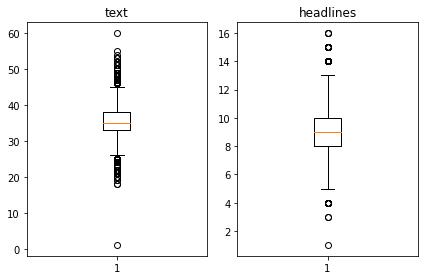

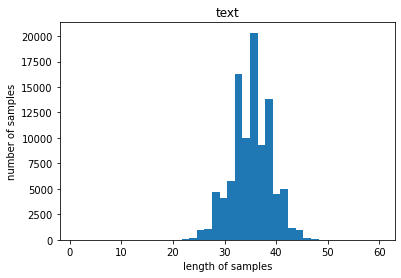

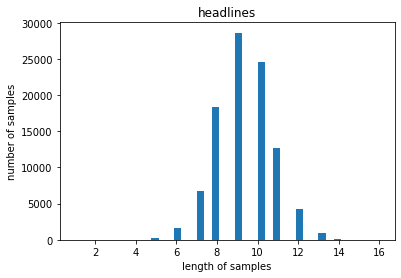

In [41]:
# 샘플 최대 길이 정하기
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('텍스트의 분산 : {}'.format(np.std(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))
print('헤드라인의 분산 : {}'.format(np.std(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [38]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


In [42]:
# 최대 길이로 이정 프로젝트에서 사용했던 평균+분산*2 를 사용했다.

text_max_len = round(np.mean(text_len) + 2*np.std(text_len))
headlines_max_len = round(np.mean(headlines_len) + 2*np.std(headlines_len))
print('text_max_len : ', text_max_len)
print('headlines_max_len :', headlines_max_len )
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

text_max_len :  43
headlines_max_len : 12
전체 샘플 중 길이가 43 이하인 샘플의 비율: 0.9871797478649857
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


In [43]:
# max_len 보다 길면 제외하는 방법으로 데이터를 정제
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 95935


#### 시작토큰과 종료 토큰 추가하기
- headlines 데이터에 토큰 추가 : 시작 토큰 sostoken, 종료 토큰 eostoken
- 디코더 입력 (decoder_input) : sostoken + ~
- 티코더 출력 (decoder_target) : ~ + eostoken
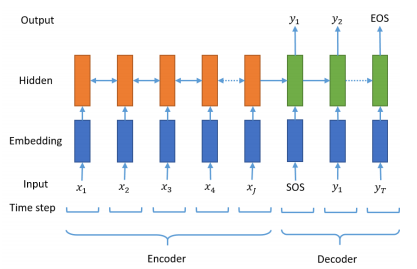

https://arxiv.org/pdf/1812.02303.pdf

In [44]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
6,india get all out for their lowest odi total i...,india recorded lowest odi total new zealand ge...,sostoken india get all out for their lowest od...,india get all out for their lowest odi total i...


In [45]:
# 데이터를 넘파이 타입으로 저장
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


#### 훈련데이터 , 테스트 데이터 분할

In [46]:
# encoder_input과 크기와 형태가 같은, 순서가 섞인 정수 시퀀스 생성
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[79122 32705 47315 ... 85757 85747 11045]


In [47]:
# 상기 시퀀스로 데이터의 샘플순서를 지정하면, 잘 섞인 샘플이 된다.
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


In [48]:
# 테스트데이터 수 확인
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19187


In [49]:
# 분할
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 76748
훈련 레이블의 개수 : 76748
테스트 데이터의 개수 : 19187
테스트 레이블의 개수 : 19187


### 정수 인코딩
각 단어에 고유한 정수를 맵핑,  단어 집합(vocabulary) 을 만든다
원문에 해당되는 encoder_input_train에 대해서 단어 집합을 만들자


In [50]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


각 단어에 고유한 정수가 부여됨.

생성된 단어 집합은 src_tokenizer.word_index에 저장됨.

모든 단어를 사용하는 것이 아니라, 빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행

빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인

src_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장되어 있다.

In [51]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 68572
등장 빈도가 6번 이하인 희귀 단어의 수: 46737
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 21835
단어 집합에서 희귀 단어의 비율: 68.15755702035815
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.540521503459841


6회 이하 등장빈도를 가지는 단어는 단어 집합에서 68%를 차지한다.

반면, 전체 등장 빈도에서 희귀단어의 등장 빈도는 3.5%로 상대적으로 적은 수치이다.

따라서, 6회 이하 단어들은 정수 인코딩 과정에서 제외하고, 훈련데이터에서 제거하자. 

이를 제외한단어집합의 크기가 2만1개 정도이기 때문에 단어집합의 크기를 2만으로 제한하자.

토크나이저 정의에서, num_words값으로 단어집합의 크기를 제한할 수 있다.

In [52]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


texts_to_sequences()로 생성된 단어 집합에 기반하여,
입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행

In [53]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[6065, 3715, 3401, 11397, 59, 1, 1776, 643, 585, 1665, 3462, 338, 442, 348, 676, 2053, 2543, 831, 50, 64, 26, 155, 4442, 176, 3835, 29, 11, 22, 76], [561, 4959, 1719, 1715, 1658, 283, 1395, 4624, 56, 196, 92, 205, 72, 916, 3402, 1719, 1715, 2019, 1167, 339, 1719, 1715, 578, 1343, 2779, 1220, 1220, 1405, 1848, 528, 685, 34, 1719, 1715, 617], [899, 180, 1, 568, 488, 141, 122, 12004, 5168, 334, 124, 1168, 182, 4, 205, 1150, 604, 14, 4354, 7554, 10051, 7924, 10, 279, 122, 1570, 334, 279, 10531, 214, 386]]


headlines 데이터도 동일하게 정수 인코딩.

In [54]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


고유한 정수가 tar_tokenizer.word_index에 저장되어 있어요.

tar_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장.

등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인

In [60]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29720
등장 빈도가 5번 이하인 희귀 단어의 수: 19455
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10265
단어 집합에서 희귀 단어의 비율: 65.46096904441454
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.743606849010452


5회 이하 단어 단어집합에서 65%차지

전체 등장 빈도에서 희귀단어 빈도 비율 : 4.7%

5회 이하로 할 경우 단어집합 크기 10265개

약 1만개 단어 집합으로 제한하자.

In [61]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 172, 965, 7, 412, 49, 791, 525], [1, 659, 54, 939, 19, 186, 255, 7, 1001], [1, 270, 45, 271, 3, 131, 450, 408], [1, 374, 303, 277, 7, 132], [1, 291, 835, 1654, 6, 18, 39, 17]]
target
decoder  [[172, 965, 7, 412, 49, 791, 525, 2], [659, 54, 939, 19, 186, 255, 7, 1001, 2], [270, 45, 271, 3, 131, 450, 408, 2], [374, 303, 277, 7, 132, 2], [291, 835, 1654, 6, 18, 39, 17, 2]]


- 정수 인코딩 완료
- 패딩하기로 넘어가기전 점검해야 할 것.
> 낮은 빈도수 삭제->빈 샘플 존재 가능.

- 길이가 짧은 headlines 에서 빈샘플이 있을 가능성이 높다.
- 토큰이 추가되어 있기 때문에, 길이가 0인 헤드라인은 실제 1로 나타난다.

In [62]:
#길이가 1인 경우의 인덱스를 각각 drop_train, drop_test에 저장. 후 삭제
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 12
삭제할 테스트 데이터의 개수 : 3
훈련 데이터의 개수 : 76736
훈련 레이블의 개수 : 76736
테스트 데이터의 개수 : 19184
테스트 레이블의 개수 : 19184


#### 패딩하기
서로 다른 길이의 샘플을 병렬처리하기 위해, 같은 길이로 맞푸는 패딩작업.

최대 길이보다 짧은 데이터는들의 뒤의 공간에 0을 넣어 최대 길이로 맞춰준다.

In [64]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')
print('=3')

=3


### 전처리 완료

# Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

In [66]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [67]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [68]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 43)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 43, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 43, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [69]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 43)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 43, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 43, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [70]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
300/300 [==============================] - 182s 580ms/step - loss: 3.8899 - val_loss: 3.5938
Epoch 2/50
300/300 [==============================] - 171s 570ms/step - loss: 3.4082 - val_loss: 3.2233
Epoch 3/50
300/300 [==============================] - 170s 566ms/step - loss: 3.1317 - val_loss: 3.0317
Epoch 4/50
300/300 [==============================] - 170s 566ms/step - loss: 2.9510 - val_loss: 2.9019
Epoch 5/50
300/300 [==============================] - 169s 565ms/step - loss: 2.8148 - val_loss: 2.7987
Epoch 6/50
300/300 [==============================] - 169s 563ms/step - loss: 2.7026 - val_loss: 2.7165
Epoch 7/50
300/300 [==============================] - 169s 563ms/step - loss: 2.6084 - val_loss: 2.6581
Epoch 8/50
300/300 [==============================] - 169s 564ms/step - loss: 2.5268 - val_loss: 2.6025
Epoch 9/50
300/300 [==============================] - 169s 564ms/step - loss: 2.4548 - val_loss: 2.5625
Epoch 10/50
300/300 [==============================] - 169s 565m

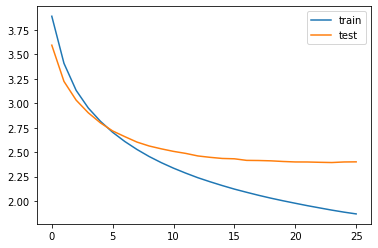

In [71]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.

#### 인퍼런스 모델

In [72]:
# 단어 사전
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

seq2seq 훈련단계 : 디코더 입력부에 정답문장 전체 입력, 디코더의 출력과 한번에 비교 하므로 인코더와 디코더를 엮은 통짜 모델하나 준비.
인퍼런스 단계 : 정답 문장이 없다. 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야한다. 따라서 인퍼런스 모델을 별도로 설계해야한다. 인코더 모델과 디코더 모델을 분리해서 설계

In [73]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


In [74]:
# 어텐션 메커니즘을 사용하는 출력층 설계
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


In [78]:
# 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


#### 모델 테스트

정수시퀀스를 텍스트 시퀀스로 변환하는 함수.
- 패딩 0 제외
- Headlines의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외

In [76]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


In [99]:
# 10개 만 확인해보자.
for i in range(10):
    print(i+1, '번째 문장')
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

1 번째 문장
원문 : video surfaced online wherein suspended congress leader mani shankar aiyar seen snatching mike news channel republic tv reporter video starts aiyar apologising using word neech could misinterpreted describe pm narendra modi reporter heard asking aiyar repeatedly would apologise 
실제 요약 : video tv 
예측 요약 :  leader who hacked to news


2 번째 문장
원문 : delhi police arrested year old dancer told police robbed pizza outlet spend girlfriends fulfil dream working bollywood adnan khan along three friends allegedly robbed outlet lakh december allegedly planning robberies moving mumbai 
실제 요약 : to spend on act in 
예측 요약 :  delhi man arrested for actress


3 번째 문장
원문 : lebanese rock band barred performing concert jordan second year row lawmakers objected lead singer sexuality adding band opinions lyrics sexuality norms country official said people firm say hosting band 
실제 요약 : bans with gay lead singer 
예측 요약 :  banned at concert


4 번째 문장
원문 : rss chief mohan bhagwat monday said organi

#### 해석
- 대체적으로 예측이 이루어지지 않은 것으로 보인다.
- 3, 6, 7, 9, 10 번째 문장에서 첫 단어는 실제요약과 같거나 유사한 단어를 예측하였다.

# Step 5. Summa을 이용해서 추출적 요약해보기
추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

Summa의 summarize를 사용하여 추출적 요약을 해보세요.

In [80]:
import requests
from summa.summarizer import summarize

Summa의 summarize()의 인자
- text (str) : 요약할 테스트.
- ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
- words (int or None, optional) – 출력에 포함할 단어 수.
- 만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.
- split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환

Summa의 summarize는 내부적으로 문장 토큰화를 수행한다.

In [107]:
text= pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [109]:
for i in range(10):
    print(i+1, '번째 문장')
    print("원문 :", text['text'][i])
    print("실제 요약 :", text['headlines'][i])
    print("summarize 요약 :", summarize(text['text'][i], ratio=0.4))
#     print("실제 요약 :", seq2headlines(decoder_input_test[i]))
#     print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

1 번째 문장
원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
summarize 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.


2 번째 문장
원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED
summarize 요약 : Users get one C

#### 해석_추출적 요약
- 추상적 요약보다 완성된 문장과 같은 예측을 하였다.
- 살펴보니 단순이 본문에 포함된 문장과 정확히 일치 하였다. 
>- 1, 2, 3, 4, 7 번째 문장은 원문의 마지막문장과 같고
>- 5, 6, 10 번째 문장은 원문의 첫 문장과 일치하였다.

- 사실상 요약이라고 보기 어려운 성능이다.
- ratio 인자를 0.5, 0.4 , 0.3으로 변경하여 보았을때, 수치가 낮을 수록 8, 9 번째 문장과 같이 빈문장을 요약하는 수가 늘어났다. 본문의 길이가 충분히 길지 않아서 그런듯하다.

***
루브릭


1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.

분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.

2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.

모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었다.

3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.

두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였다.
***

# 회고
1. 어려웠던점
- 추출적 요약에서 데이터로, 추상적요약에 사용한 전처리된 데이터를 사용하였더니 결과가 전혀나오지 않아서 당황했다.
- 원문의 길이가 짧아서 추출적요약의 결과가 단순히 원문의 첫문장이나 마지막문장을 그대로 나왔다. 이를 개선 및 해결할 방안이 떠오르지 않아 어려웠다.

2. 느낀점
- 자연어 프로젝트는 이미지 프로젝트에 비해 전반적으로 모델학습이나, 구조 진행과정이 추상적인 느낌이다. 또 그만큼 도전적이기도 하지만 여전히 어렵다.